In [1]:
import pandas as pd
import dotenv

dotenv.load_dotenv()

True

In [2]:
df = pd.read_csv("data/samsung-labeled-transformed.csv")
df.head()

,question,sentiment,answer
0,What are the top 3 benefits of Galaxy AI?,very_positive,The top 3 benefits of the Galaxy AI are: unpar...
1,What are the main differences between the Sams...,very_positive,The main differences between the Samsung Galax...
2,Does the Samsung Galaxy S23 Ultra support 8K v...,very_positive,Absolutely! The Samsung Galaxy S23 Ultra does ...
3,How does the battery life of the Galaxy S23+ c...,very_positive,The Galaxy S23+ offers a remarkable battery li...
4,Can I use a stylus with the Samsung Galaxy S23...,very_positive,Absolutely! The Samsung Galaxy S23 Ultra is de...


In [65]:
import json
from typing import Any
import dspy
from sklearn.model_selection import train_test_split

model = "claude-3-haiku"

# Set up the LM
llm = dspy.OpenAI(
    model_type="chat",
    model=f"anthropic/{model}-20240307",
    api_base="http://localhost:8080/proxy/v1/",
    max_tokens=2048,
    tools=[
        {
            "type": "function",
            "function": {
                "name": "sentiment",
                "parameters": {
                    "type": "object",
                    "properties": {
                        # "reasoning": {
                        #     "type": "string",
                        #     "description": "reason about the output tone and intensity before giving the final veredict on the sentiment, \
                        #         notice that there are no neutral options, you have to decide if the output tends more towards positive or negative"
                        # },
                        "sentiment": {
                            "type": "string",
                            "enum": ["very_positive", "subtly_positive", "subtly_negative", "very_negative"],
                            "description": "the sentiment of the output following one of the 4 options",
                        }
                    },
                    "required": ["reasoning", "sentiment"],
                },
                "description": "use this function if you need to give your veredict on the sentiment, NOT for reasoning",
            },
        },
    ],
    temperature=0,
    # tool_choice={"type": "function", "function": {"name": "sentiment"}},
)


def _get_choice_text(self, choice: dict[str, Any]) -> str:
    prompt : str = self.history[-1]['prompt']
    if self.model_type == "chat":
        message = choice["message"]
        if content := message["content"]:
            return content
        elif tool_calls := message.get("tool_calls", None):
            arguments = json.loads(tool_calls[0]["function"]["arguments"])
            if prompt.endswith("Reasoning:"):
                return arguments["reasoning"] + "\nSentiment: " + arguments["sentiment"]
            else:
                return arguments["sentiment"]
    return choice["text"]



llm._get_choice_text = _get_choice_text.__get__(llm)

print(llm("hello there"))

dspy.settings.configure(lm=llm)

# Load math questions from the GSM8K dataset
dataset = []
for _, row in df.iterrows():
    dataset.append(
        dspy.Example(output=row.answer, sentiment=row.sentiment).with_inputs("output")
    )
trainset, devset = train_test_split(dataset, train_size=50, test_size=0.1)
print("trainset len", len(trainset))
trainset[0:10]

['very_positive']
trainset len 50


[Example({'output': "Absolutely! The Samsung Galaxy Tab S9 is perfect for video editing. Its powerful Snapdragon 8 Gen 2 processor, stunning AMOLED display, and S Pen support make it the best tablet on the market for creatives. You'll experience seamless performance and vibrant visuals, ensuring your editing projects are both enjoyable and professional.", 'sentiment': 'very_positive'}) (input_keys={'output'}),
 Example({'output': 'The Galaxy Z Flip 4 offers competitive battery life for a foldable device, with a 3,700mAh battery that typically lasts through a full day of moderate use. While traditional smartphones may edge out in longevity due to larger batteries, the Z Flip 4 balances performance and portability effectively. Its power management and fast charging capabilities are also notable strengths.', 'sentiment': 'subtly_positive'}) (input_keys={'output'}),
 Example({'output': "Yes, the Samsung Galaxy Z Fold 4 comes with a pre-applied screen protector on its inner display. This ad

In [10]:
from typing import Literal

from pydantic import BaseModel, Field


class Sentiment(BaseModel):
    sentiment: Literal["very_positive", "subtly_positive", "subtly_negative", "very_negative"] = Field(description="The sentiment of the output following one of the 4 options")


class ProductSentimentPolaritySignature(dspy.Signature):
    """Classify the sentiment of the output."""

    output = dspy.InputField(desc="Output of LLM talking about product specifications.")
    sentiment : Sentiment = dspy.OutputField()

class ProductSentimentPolarity(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.Predict(ProductSentimentPolaritySignature)

    def forward(self, output):
        return self.prog(output=output)

dev_example = devset[0]
print(dev_example)

pred = ProductSentimentPolarity()(output=dev_example.output)
pred

Example({'output': "The Samsung Galaxy Tab S9+ is exceptionally durable, featuring an armor aluminum frame and Gorilla Glass for superior protection. It's also IP68 water and dust resistant, making it one of the toughest tablets on the market. If you want reliability and longevity in a high-performance tablet, the Galaxy Tab S9+ is the best option available.", 'sentiment': 'very_positive'}) (input_keys={'output'})


Prediction(
    sentiment='very_positive'
)

In [5]:
# %cd /Users/rchaves/Projects/langwatch-saas/langwatch/python-sdk/
# %pip install .

import langwatch

langwatch.endpoint = "http://localhost:3000"
langwatch.login()

Please go to http://localhost:3000/authorize to get your API key
LangWatch API key set


In [28]:
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch


def sentiment_matches(example, pred, trace=None):
    return example.sentiment == pred.sentiment


optimizer = BootstrapFewShotWithRandomSearch(
    metric=sentiment_matches,
    max_bootstrapped_demos=16,
    max_labeled_demos=4,
    max_rounds=1,
    num_candidate_programs=16,
)

langwatch.dspy.init(
    experiment="product_sentiment_polarity_anthropic", optimizer=optimizer
)

optimized_evaluator = optimizer.compile(ProductSentimentPolarity(), trainset=trainset)

Experiment initialized, run_id: primitive-precise-cicada
Open http://localhost:3000/inbox-narrator/experiments/product_sentiment_polarity_anthropic?runIds=primitive-precise-cicada to track your DSPy training session live



  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
from dspy.evaluate import Evaluate

# Set up the evaluator, which can be used multiple times.
evaluate_train = Evaluate(devset=trainset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)
evaluate_dev = Evaluate(devset=devset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0)

# Evaluate our `optimized_cot` program.
train_score = evaluate_train(optimized_evaluator)
dev_score = evaluate_dev(optimized_evaluator)
train_score, dev_score

Average Metric: 27 / 41  (65.9): 100%|██████████| 41/41 [00:00<00:00, 3769.79it/s]


(56.0, 65.85)

In [66]:
import os
if not os.path.exists('./results'):
    os.makedirs('./results')
optimized_evaluator.save(f"./results/{langwatch.dspy.experiment_slug}_{model}_merry-thankful-spaniel_train_{train_score}_dev_{dev_score}.json")

Average Metric: 27 / 41  (65.9): 100%|██████████| 41/41 [00:00<00:00, 1152.94it/s]


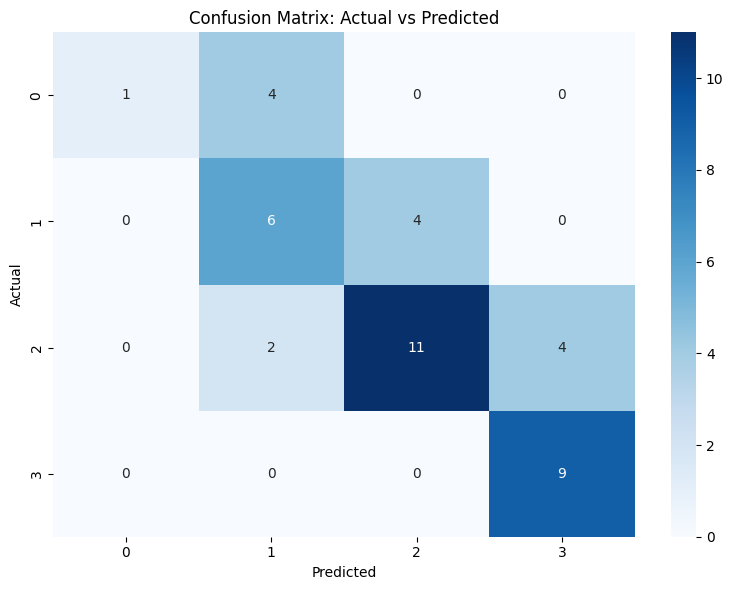

In [59]:
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# optimized_evaluator = ProductSentimentPolarity()
# optimized_evaluator.load("./product_sentiment_polarity_anthropic_no_reasoning_v1_80.json")
# optimized_evaluator(output=dev_example.output)

evaluate = Evaluate(devset=devset, metric=sentiment_matches, num_threads=4, display_progress=True, display_table=0, return_outputs=True)
score, results = evaluate(optimized_evaluator) # type: ignore

sentiment_map = {
  "very_positive": 3,
  "subtly_positive": 2,
  "subtly_negative": 1,
  "very_negative": 0
}

y = [sentiment_map[example[0].sentiment] for example in results]
y_pred = [sentiment_map[example[1].sentiment] for example in results]


conf_matrix = confusion_matrix(y, y_pred)

# Plotting confusion matrices
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix: Actual vs Predicted')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()


In [61]:
[example for example in results if example[0].sentiment != example[1].sentiment]

[(Example({'output': 'The Samsung Galaxy Tab S9 Ultra boasts a large 14.6-inch Super AMOLED display with a 120Hz refresh rate, providing a crisp and smooth visual experience. It is powered by the Snapdragon 8 Gen 1 processor, ensuring robust performance. Additionally, it features a dual camera setup, S Pen support, and a substantial 11,200mAh battery, making it well-suited for both productivity and entertainment.', 'sentiment': 'subtly_positive'}) (input_keys={'output'}),
  Prediction(
      sentiment='very_positive'
  ),
  False),
 (Example({'output': "The top three benefits of Galaxy AI could be personalized user experience, enhanced camera features with scene recognition, and improved battery performance. While these features are quite useful, it's good to note that several other smartphone brands offer similar, if not superior, AI capabilities in their devices.", 'sentiment': 'subtly_negative'}) (input_keys={'output'}),
  Prediction(
      sentiment='subtly_positive'
  ),
  False),